In [1]:
# general
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

import GPUtil

# torch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import random_split

from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

import torch.nn as nn
import torchvision.models as models
from pytorch_pretrained_bert import BertModel, BertForSequenceClassification
from transformers import DistilBertModel
import torch.nn.functional as F

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords

Using TensorFlow backend.


In [2]:
# Reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

In [3]:
df = pd.read_pickle('../data/labeled_data.p')

# analyze imbalance
print(df["class"].value_counts())

# drop class 1 for the first
df = df.drop(df[df['class'] == 1].index)
df = df.drop(['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)

# convert class 2 -> 1 to be in accordance with standards
def convert_standard(x):
    return 0 if x == 0 else 1
df['class'] = df['class'].apply(convert_standard)

df = df[:10]
print(df["class"].value_counts())

print(df.head(10))

# initialize list of lists 
data = [['xavier likes to go out', 0], ['i would like to by a book', 1], ['the pen is blue', 0],
        ['nver before I did this', 0], ['such an amazing day', 1], ['the light is red', 1]] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['tweet', 'class']) 

print(df.head())

1    19190
2     4163
0     1430
Name: class, dtype: int64
1    7
0    3
Name: class, dtype: int64
     class                                              tweet
0        1  !!! RT @mayasolovely: As a woman you shouldn't...
40       1    " momma said no pussy cats inside my doghouse "
63       1  "@Addicted2Guys: -SimplyAddictedToGuys http://...
66       1  "@AllAboutManFeet: http://t.co/3gzUpfuMev" woo...
67       1  "@Allyhaaaaa: Lemmie eat a Oreo &amp; do these...
70       1  "@ArizonasFinest6: Why the eggplant emoji doe?...
75       1  "@BabyAnimalPics: baby monkey bathtime http://...
85       0  "@Blackman38Tide: @WhaleLookyHere @HowdyDowdy1...
90       0  "@CB_Baby24: @white_thunduh alsarabsss" hes a ...
111      0  "@DevilGrimz: @VigxRArts you're fucking gay, b...
                       tweet  class
0     xavier likes to go out      0
1  i would like to by a book      1
2            the pen is blue      0
3     nver before I did this      0
4        such an amazing day      1


In [4]:
# sentence length (in #words)
# https://textblob.readthedocs.io/en/dev/
sentence_length = np.zeros(len(df))

for i in range(len(df)):
    text_string = df['tweet'].values[i]
    sentence_length[i] = len(text_string.split()) 
    
print('Mean sentence length: '+ str(np.round(np.mean(sentence_length), 2)))
print('Max sentence length: '+ str(np.round(np.max(sentence_length), 2)))
print('MIn sentence length: '+ str(np.round(np.min(sentence_length), 2)))

Mean sentence length: 4.83
Max sentence length: 7.0
MIn sentence length: 4.0


In [5]:
import re
def preprocess(text):

    text=text.lower()
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    #Replace &amp, &lt, &gt with &,<,> respectively
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    #remove hashtag sign
    #text=re.sub(r"#","",text)   
    #remove mentions
    text = re.sub(r"(?:\@)\w+", '', text)
    #text=re.sub(r"@","",text)
    #remove non ascii chars
    text=text.encode("ascii",errors="ignore").decode()
    #remove some puncts (except . ! ?)
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    
    text=" ".join(text.split())
    return text

df['tweet'] = df['tweet'].apply(preprocess)
df = df[df["tweet"]!='']

print(df.head())


                       tweet  class
0     xavier likes to go out      0
1  i would like to by a book      1
2            the pen is blue      0
3     nver before i did this      0
4        such an amazing day      1


In [6]:
# dictionary
data = df.to_dict(orient='records') # have been shuffled in previous step

# train valid split
from sklearn.model_selection import train_test_split
train_data, valid_data = train_test_split(data, test_size=0.2)

# split into text (input) and labels (output)
train_tweets, train_labels = list(zip(*map(lambda d: (d['tweet'], d['class']), train_data)))
valid_tweets, valid_labels = list(zip(*map(lambda d: (d['tweet'], d['class']), valid_data)))

In [7]:
print(train_tweets[:10])

# bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:14] + ['[SEP]'], train_tweets))
valid_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:14] + ['[SEP]'], valid_tweets))

print(train_tokens[:10])

# token to id & padding
train_token_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=16, truncating="post", padding="post", dtype="int")
valid_token_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, valid_tokens)), maxlen=16, truncating="post", padding="post", dtype="int")

print(train_token_ids[:2])

('i would like to by a book', 'nver before i did this', 'xavier likes to go out', 'such an amazing day')
[['[CLS]', 'i', 'would', 'like', 'to', 'by', 'a', 'book', '[SEP]'], ['[CLS]', 'n', '##ver', 'before', 'i', 'did', 'this', '[SEP]'], ['[CLS]', 'x', '##avi', '##er', 'likes', 'to', 'go', 'out', '[SEP]'], ['[CLS]', 'such', 'an', 'amazing', 'day', '[SEP]']]
[[ 101  178 1156 1176 1106 1118  170 1520  102    0    0    0    0    0
     0    0]
 [ 101  183 4121 1196  178 1225 1142  102    0    0    0    0    0    0
     0    0]]


In [8]:
# put everything back into a dictionary
train_data = {'tokens': train_tokens, 'labels': train_labels}
valid_data = {'tokens': valid_tokens, 'labels': valid_labels}

# mask -> required by bert
train_masks = [[float(i > 0) for i in ii] for ii in train_token_ids]
valid_masks = [[float(i > 0) for i in ii] for ii in valid_token_ids]

print(train_masks[:2])

[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


In [9]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 4

# Create the DataLoader for our training set.
train_data = TensorDataset(torch.tensor(train_token_ids),
                           torch.tensor(train_masks),
                           torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(torch.tensor(valid_token_ids),
                                torch.tensor(valid_masks),
                                torch.tensor(valid_labels))
validation_sampler = SequentialSampler(validation_data)
valid_loader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [10]:
# bert model class
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')
        
        # freeze weights
        #for param in self.bert.parameters():
        #    param.requires_grad = False
        
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        #dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(pooled_output)
        proba = self.sigmoid(linear_output)
        return proba


In [11]:
# bert model class
class BertBinaryClassifier(nn.Module):
    def __init__(self):
        super(BertBinaryClassifier,self).__init__()
        self.fc1 = nn.Linear(16, 4024)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        
        self.fc2 = nn.Linear(4024, 1)
        torch.nn.init.xavier_uniform(self.fc2.weight)
        
        self.relu1 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):    
        tokens = tokens.float()
        out1 = self.relu1(self.fc1(tokens))
        out2 = self.sigmoid(self.fc2(out1))
        
        return out2


In [29]:
vector = torch.rand(4, 16)
lables = torch.tensor([0, 1, 1, 0])

model2 = BertBinaryClassifier()

from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import roc_auc_score

# training
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

EPOCHS=100

# binary cross entropy loss (classification)
loss_func = nn.BCELoss()

# monitor train progress
stats = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': [], 'val_rocauc': []}

time_tot = []


for epoch_num in range(EPOCHS):
    #
    train_loss = 0.
    train_correct = 0.
    
    # optimizer lr decay
    #optimizer = Adam(model.parameters(), lr=1e-5)
    
    # training
    model.train()
        
    for idx in range(4):
        
        # sample = {token_id': token_id, 'mask': mask, 'label': label}        
        
        outputs = lables[idx].to(device)
        inputs = vector[idx].to(device)
        logits = model(inputs)
   
        # loss
        batch_loss = weighted_binary_cross_entropy(logits, outputs.float())
        train_loss += batch_loss.item()
        
        #print(batch_loss)
        
        train_correct += sum(torch.round(logits)==outputs).item()
        
        # reset gradient and calculate new ones
        model.zero_grad()
        batch_loss.backward()
        
        optimizer.step()
        
    # train stats
    stats['train_loss'].append(train_loss / ((step_num+1)* batch_size))
    stats['train_acc'].append(train_correct / ((step_num+1)* batch_size))
    
    writer.add_scalar('Loss/train', train_loss / ((step_num+1)* batch_size), epoch_num)
    writer.add_scalar('Accuracy/train', train_correct / ((step_num+1)* batch_size), epoch_num)
    
writer.close()



/home/roman/torch/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/home/roman/torch/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if __name__ == '__main__':


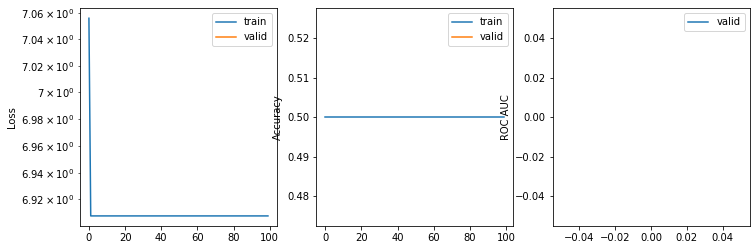

In [30]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
ax[0].plot(stats['train_loss'])
ax[0].plot(stats['valid_loss'])
ax[0].legend(['train', 'valid'])
ax[0].set_ylabel('Loss')
ax[0].set_yscale('log')

ax[1].plot(stats['train_acc'])
ax[1].plot(stats['valid_acc'])
ax[1].legend(['train', 'valid'])
ax[1].set_ylabel('Accuracy')

ax[2].plot(stats['val_rocauc'])
ax[2].legend(['valid'])
ax[2].set_ylabel('ROC AUC')

plt.savefig('../classifier_11_10.png')
plt.show()

In [14]:
# allocate on gpu
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

model = BertBinaryClassifier().to(device)
print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

GPUtil.showUtilization()

print(sum(p.numel() for p in model.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

/home/roman/torch/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  
/home/roman/torch/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  if __name__ == '__main__':


0.290816M
| ID | GPU | MEM |
------------------
|  0 |  3% | 11% |
72433
72433


In [15]:
def weighted_binary_cross_entropy(output, target, weights=None):
        
    if weights is not None:        
        # TODO: should work since target = {0, 1}, thus sets weights to zero if not needed
        loss = weights * (target * torch.log(output)) + \
               weights * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output + 1e-6) + (1 - target) * torch.log(1 - output+ 1e-6)

    return torch.neg(torch.mean(loss))

In [16]:
from datetime import date
# summary writer
log_dir = './summaries_pretraining/summary'+ date.today().strftime('%H-%d-%m-%Y')
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir)

In [17]:
class HatefulMemesDataset(Dataset):
    """ Hateful Memes dataset """
    
    def __init__(self, data):
        """
        Args:
            df_path (string): path to jsonl file with image id's
            root_dir (string): directory with all the images
            transform (callable): optional transform to be applied on a sample
        """
        # text
        self.data = data
        
    def __len__(self):
        return len(self.data['labels'])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx_tolist()
            
            
        data_train = {'tokens': train_tokens, 'masks': train_masks, 'labels': train_labels}
        
        # label ------------------------------------------
        label = self.data['labels'][idx]
        label = np.array([label])
        label = label.astype('int').reshape(-1)
        
        # token -------------------------------------------
        token = self.data['tokens'][idx]
        
        # prepare token ids: each token (word fragment) corresponds to an id in the bert corpus
        # further need to make all review the same length -> padding too short, truncating too long ones
        token_id = pad_sequences([tokenizer.convert_tokens_to_ids(token)], maxlen=16, truncating="post", padding="post", dtype="int")
        token_id = token_id.reshape(-1)
        
        # mask for padding -> required by bert
        mask = self.data['masks'][idx]
        mask = np.array([mask])
        mask = mask.astype('float').reshape(-1)
        
        #
        sample = {'token_id': token_id, 'mask': mask, 'label': label}
            
        return sample

In [18]:
from torch.optim import Adam
# TODO: not sure if this does what I think it should do
# optimizer
param_optimizer = list(model.named_parameters())
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

lr = [1e-4, 1e-5, 1e-6, 1e-7]
optimizer = Adam(model.parameters(), lr=10) # TODO: SGD for just the final classifier

In [19]:
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import roc_auc_score

# training
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

EPOCHS=100

# binary cross entropy loss (classification)
loss_func = nn.BCELoss()

# monitor train progress
stats = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': [], 'val_rocauc': []}

time_tot = []

# training
data_train = {'tokens': train_tokens, 'masks': train_masks, 'labels': train_labels}


train_dataset = HatefulMemesDataset(data_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=1, shuffle=True)


for epoch_num in range(EPOCHS):
    #
    train_loss = 0.
    train_correct = 0.
    
    # optimizer lr decay
    #optimizer = Adam(model.parameters(), lr=1e-5)
    
    # training
    model.train()
        
    for step_num, batch in enumerate(train_loader):
        
        # sample = {token_id': token_id, 'mask': mask, 'label': label}        
        
        labels = batch['label'].to(device)
        masks = batch['mask'].to(device)
        token_ids = batch['token_id'].to(device)
        # imgs, token_ids, masks, labels = tuple(t.to(device) for t in batch)
        # print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = model(token_ids, masks)
        
        # account for class imbalance (66% label 0, 33% label 1)
        eye = torch.ones(labels.shape, device=device)
        weight_imbalance = (eye+ (labels==eye).int())* 0.63
   
        # loss
        batch_loss = weighted_binary_cross_entropy(logits, labels.float())
        train_loss += batch_loss.item()
        
        #print(batch_loss)
        
        train_correct += sum(torch.round(logits)==labels).item()
        
        # reset gradient and calculate new ones
        model.zero_grad()
        batch_loss.backward()
        
        optimizer.step()
        
        # gradient clipping and backward pass
        #clip_grad_norm_(parameters=model.parameters(), max_norm=10)

        # logging
        # clear_output(wait=True) -> from IPython.display import clear_output
        if step_num%100==0 and step_num> 0:
            print('Epoch: ', epoch_num + 1)
            print("\r" + "{0}/{1} loss: {2} acc: {3} ".format(step_num,
                                                              len(train_data) / batch_size,
                                                              round(train_loss / (step_num + 1), 3),
                                                              round(train_correct/ ((step_num+1)* batch_size), 3)))
    
    
    # train stats
    stats['train_loss'].append(train_loss / ((step_num+1)* batch_size))
    stats['train_acc'].append(train_correct / ((step_num+1)* batch_size))
    
    writer.add_scalar('Loss/train', train_loss / ((step_num+1)* batch_size), epoch_num)
    writer.add_scalar('Accuracy/train', train_correct / ((step_num+1)* batch_size), epoch_num)
    
writer.close()

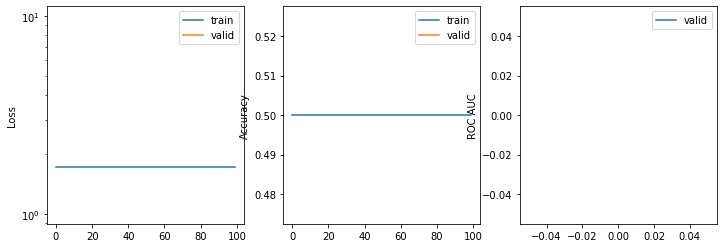

In [20]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
ax[0].plot(stats['train_loss'])
ax[0].plot(stats['valid_loss'])
ax[0].legend(['train', 'valid'])
ax[0].set_ylabel('Loss')
ax[0].set_yscale('log')

ax[1].plot(stats['train_acc'])
ax[1].plot(stats['valid_acc'])
ax[1].legend(['train', 'valid'])
ax[1].set_ylabel('Accuracy')

ax[2].plot(stats['val_rocauc'])
ax[2].legend(['valid'])
ax[2].set_ylabel('ROC AUC')

plt.savefig('../classifier_11_10.png')
plt.show()